In [1]:
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from fastapi import FastAPI, File, UploadFile, HTTPException
from fastapi.responses import JSONResponse
import cv2
import numpy as np
import onnxruntime
import onnx
import time

In [2]:
def letterbox_image(image, size):
    '''Resize image with unchanged aspect ratio using padding'''
    iw, ih = image.size
    w, h = size
    scale = min(w/iw, h/ih)
    nw = int(iw*scale)
    nh = int(ih*scale)

    image = image.resize((nw,nh), Image.BICUBIC)
    new_image = Image.new('RGB', size, (128,128,128))
    new_image.paste(image, ((w-nw)//2, (h-nh)//2))
    return new_image

def preprocess(img):
    model_image_size = (640, 640)
    boxed_image = letterbox_image(img, tuple(reversed(model_image_size)))
    image_data = np.array(boxed_image, dtype='float32')
    image_data /= 255.
    image_data = np.transpose(image_data, [2, 0, 1])
    image_data = np.expand_dims(image_data, 0)
    return image_data

In [3]:
classes = ['dolly', 'bin', 'jack']
classes[0:5]

['dolly', 'bin', 'jack']

In [106]:
img = Image.open('../BMW_dataset/images/test/1.jpg')
img_data = preprocess(img)
img_size = np.array([img.size[1], img.size[0]], dtype=np.float32).reshape(1, 2)
img_data.shape

(1, 3, 640, 640)

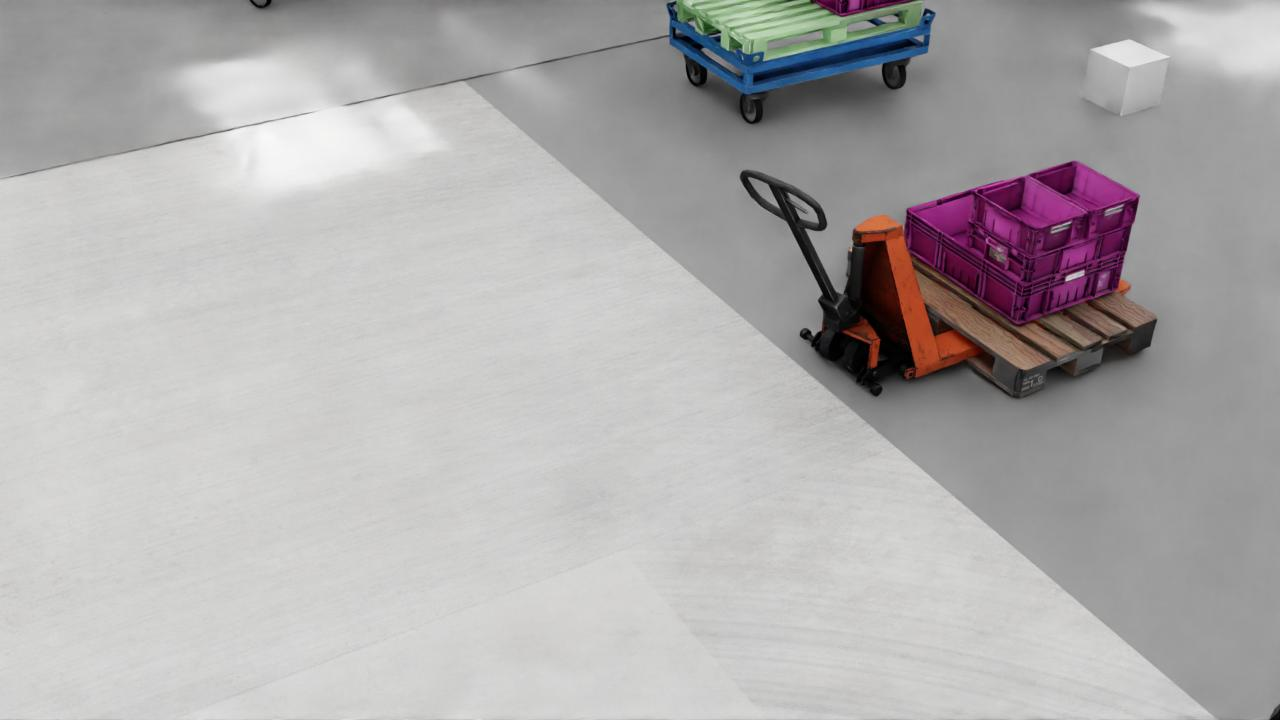

In [107]:
img

In [108]:
MODEL_PATH = '../weights/best.onnx'

# Load the model
ort_session = onnxruntime.InferenceSession(MODEL_PATH)

In [109]:
start = time.time()
output = ort_session.run(None, {"images": img_data})
end = time.time()

inference_time = np.round(end - start, 2)
print("Inference time: ", inference_time, " sec")

Inference time:  0.37  sec


In [110]:
output[0].shape

(1, 25200, 8)

In [111]:
matrix = output[0][0]

In [114]:
# Assuming 'matrix' is your 25200 by 8 numpy array
sorted_matrix = matrix[matrix[:, 4].argsort()[::-1]]  # Sort based on value at index 4 in descending order
top_4_rows = sorted_matrix[:4]  # Keep the top 4 rows

# If you need to keep the original order of the rows, you can do the following:
# indices = matrix[:, 4].argsort()[::-1]
# top_4_rows = matrix[indices[:4]]

print(top_4_rows)


[[3.9983826e+02 1.6515396e+02 1.3521606e+02 4.5059570e+01 9.4598866e-01
  9.9990833e-01 7.2866678e-05 2.1246076e-04]
 [4.0014905e+02 1.6477512e+02 1.3549289e+02 4.5438290e+01 9.3598151e-01
  9.9988782e-01 1.3914704e-04 2.4753809e-04]
 [3.9965842e+02 1.6481056e+02 1.3538264e+02 4.5025421e+01 9.3388885e-01
  9.9926865e-01 7.7822804e-04 1.2893677e-03]
 [4.0001010e+02 1.6526523e+02 1.3659970e+02 4.4964088e+01 9.1802996e-01
  9.9986088e-01 2.0450354e-04 4.5931339e-04]]


x_center y_center width height objectness_score p_cls1 p_cls2 p_cls3